# Final competition of Deep Learning 2020 Spring
Traffic environment semi-supervised Learning Contest

## Goals
The objective is to train a model using images captured by six different cameras attached to the same car to generate a top down view of the surrounding area. The performance of the model will be evaluated by (1) the ability of detecting objects (like car, trucks, bicycles, etc.) and (2) the ability to draw the road map layout.

## Data
You will be given two sets of data:

 1. Unlabeled set: just images
 2. Labeled set: images and the labels(bounding box and road map layout)

This notebook will help you understand the dataset.

In [1]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
from helper import compute_ats_bounding_boxes, compute_ts_road_map

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

In [3]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '../data'
annotation_csv = '../data/annotation.csv'

In [4]:
## scence
!ls ../data

annotation.csv	scene_115  scene_133  scene_31	scene_5   scene_68  scene_86
scene_0		scene_116  scene_14   scene_32	scene_50  scene_69  scene_87
scene_1		scene_117  scene_15   scene_33	scene_51  scene_7   scene_88
scene_10	scene_118  scene_16   scene_34	scene_52  scene_70  scene_89
scene_100	scene_119  scene_17   scene_35	scene_53  scene_71  scene_9
scene_101	scene_12   scene_18   scene_36	scene_54  scene_72  scene_90
scene_102	scene_120  scene_19   scene_37	scene_55  scene_73  scene_91
scene_103	scene_121  scene_2    scene_38	scene_56  scene_74  scene_92
scene_104	scene_122  scene_20   scene_39	scene_57  scene_75  scene_93
scene_105	scene_123  scene_21   scene_4	scene_58  scene_76  scene_94
scene_106	scene_124  scene_22   scene_40	scene_59  scene_77  scene_95
scene_107	scene_125  scene_23   scene_41	scene_6   scene_78  scene_96
scene_108	scene_126  scene_24   scene_42	scene_60  scene_79  scene_97
scene_109	scene_127  scene_25   scene_43	scene_61  scene_8   scene_98
scene_11	scene_128  

In [5]:
!ls ../data/scene_0

sample_0    sample_114	sample_18  sample_34  sample_50  sample_67  sample_83
sample_1    sample_115	sample_19  sample_35  sample_51  sample_68  sample_84
sample_10   sample_116	sample_2   sample_36  sample_52  sample_69  sample_85
sample_100  sample_117	sample_20  sample_37  sample_53  sample_7   sample_86
sample_101  sample_118	sample_21  sample_38  sample_54  sample_70  sample_87
sample_102  sample_119	sample_22  sample_39  sample_55  sample_71  sample_88
sample_103  sample_12	sample_23  sample_4   sample_56  sample_72  sample_89
sample_104  sample_120	sample_24  sample_40  sample_57  sample_73  sample_9
sample_105  sample_121	sample_25  sample_41  sample_58  sample_74  sample_90
sample_106  sample_122	sample_26  sample_42  sample_59  sample_75  sample_91
sample_107  sample_123	sample_27  sample_43  sample_6	 sample_76  sample_92
sample_108  sample_124	sample_28  sample_44  sample_60  sample_77  sample_93
sample_109  sample_125	sample_29  sample_45  sample_61  sample_78  sample_94
sa

In [6]:
!ls ../data/scene_0/sample_0/

CAM_BACK.jpeg	    CAM_BACK_RIGHT.jpeg  CAM_FRONT_LEFT.jpeg
CAM_BACK_LEFT.jpeg  CAM_FRONT.jpeg	 CAM_FRONT_RIGHT.jpeg


# Labeled dataset

In [7]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [8]:
labeled_scene_index = np.arange(106, 134)
train_inds = np.random.choice(labeled_scene_index,20,replace=False)
val_inds = np.array([i for i in labeled_scene_index if i not in train_inds])

In [9]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.

transform_train = transforms.Compose([torchvision.transforms.Resize((256,256)),
                                transforms.ToTensor(), 
                                transforms.Normalize([ 0.485, 0.456, 0.406 ],[ 0.229, 0.224, 0.225 ]), 
                                AddGaussianNoise(0., 0.1)])
transform_val = transforms.Compose([torchvision.transforms.Resize((256,256)),
                                transforms.ToTensor(), 
                                transforms.Normalize([ 0.485, 0.456, 0.406 ],[ 0.229, 0.224, 0.225 ])])

labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_inds,
                                  transform=transform_train,
                                  extra_info=True
                                 )
labeled_valset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=val_inds,
                                  transform=transform_val,
                                  extra_info=True
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)
valloader = torch.utils.data.DataLoader(labeled_valset, batch_size=1,shuffle=False, num_workers=2)

In [10]:
len(labeled_trainset)

2520

In [11]:
sample, target, road_image, extra = iter(trainloader).next()
print(torch.stack(sample).shape)

torch.Size([2, 6, 3, 256, 256])


## Modeling 

In [12]:
import torchvision.models as models
import copy

In [38]:
class UNet(nn.Module):
    def ConvBlock(self, in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, use_bias = False):
        block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, 
                                        stride, padding, bias = use_bias),
                              nn.BatchNorm2d(out_channels),
                              nn.ReLU(True)
                             )
        return block
    
#     def Bridge(self, in_channels, out_channels):
#         bridge = nn.Sequential(self.ConvBlock(in_channels, out_channels),
#                                self.ConvBlock(out_channels, out_channels)
#                               )
#         return bridge
    
    def UpsampleBlock(self, in_channels, out_channels, use_bias=False):
        upsample = nn.Sequential(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, bias=use_bias),
                                 nn.BatchNorm2d(out_channels),
                                 nn.ReLU(True))
        return upsample
        
    def UpsampleConv(self, in_channels, out_channels):
        upsample_conv = nn.Sequential(self.ConvBlock(in_channels, out_channels),
                                      self.ConvBlock(out_channels, out_channels))    
        return upsample_conv
        
        
    def __init__(self, num_classes, output_size, encoder='resnet18', pretrained = False, depth = 6):
        '''
        num_classes: Number of channels/classes for segmentation
        output_size: Final output size of the image (H*H)
        encoder: Supports resnet18 and resnet50 architectures
        pretrained: For loading pretrained resnet models as encoders
        '''
        super(UNet,self).__init__()  
        self.depth = depth
        self.num_classes = num_classes
        self.output_size = output_size
        
        self.resnet = torchvision.models.resnet50(pretrained=pretrained) if encoder == "resnet50" else \
                                                    torchvision.models.resnet18(pretrained=pretrained)
        self.resnet_layers = list(self.resnet.children())
        self.n = 2048 if encoder == "resnet50" else 512
        
        self.input_block = nn.Sequential(*self.resnet_layers)[:3]
        self.input_block[0] = nn.Conv2d(18, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.input_pool = self.resnet_layers[3]
        self.down_blocks = nn.ModuleList([i for i in self.resnet_layers if isinstance(i, nn.Sequential)])

        self.bridge_1_mu = self.ConvBlock(self.n, self.n)
        self.bridge_1_var = self.ConvBlock(self.n, self.n)
        self.bridge_2 = self.ConvBlock(self.n, self.n)
        
        
        self.up_blocks = nn.ModuleList([self.UpsampleBlock(self.n,self.n//2)[0],
                                        self.UpsampleBlock(self.n//2,self.n//4)[0],
                                        self.UpsampleBlock(self.n//4,self.n//8)[0],
                                        self.UpsampleBlock(self.n//8,self.n//16)[0],
                                        self.UpsampleBlock(self.n//16,self.n//32)[0]])
        
        self.up_conv = nn.ModuleList([self.UpsampleConv(self.n,self.n//2),
                                      self.UpsampleConv(self.n//2,self.n//4),
                                      self.UpsampleConv(self.n//4,self.n//8),
                                      self.UpsampleConv(self.n//16 + 64,self.n//16),
                                      self.UpsampleConv(self.n//32 + 18,self.n//32)])
        
        self.final_upsample_1 = self.UpsampleBlock(self.n//32,self.n//64)
        self.final_upsample_2 = self.UpsampleBlock(self.n//64,self.num_classes)
        
        self.final_pooling = nn.AdaptiveMaxPool2d(output_size=self.output_size)
    
    def reparameterize(self,mu,logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        skip_conn = {"layer_0": x}
        x = self.input_block(x)
        skip_conn[f"layer_1"] = x
        x = self.input_pool(x)

        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i != (self.depth - 1):
                skip_conn[f"layer_{i}"] = x
            
        mu = self.bridge_1_mu(x)
        logvar = self.bridge_1_var(x)
        x = self.reparameterize(mu,logvar)
        x = self.bridge_2(x)
        
        #print(x.shape)
    
        #x = torch.sum(x,dim=0)
        #x = x.repeat((6,1,1,1))

        for i, block in enumerate(self.up_blocks):
            key = f"layer_{self.depth - i - 2}"            
            x = block(x)
            #print(x.shape)
            x = torch.cat([x, skip_conn[key]],1)
            #print(x.shape)
            x = self.up_conv[i](x)

        del skip_conn
        
        #x = torch.sum(x,dim=0)
        x = self.final_upsample_1(x)
        x = self.final_upsample_2(x)
        x = self.final_pooling(x)

        return x,mu,logvar

In [114]:
def loss_function(x_hat, x, mu, logvar):
    #x_hat_sig = torch.sigmoid(x_hat)
    DICE =  1 - (2*torch.sum(x_hat*x))/(torch.sum(x*x) + torch.sum(x_hat*x_hat))
    MSE = F.mse_loss(
        x_hat, x, reduction='mean'
    )
    KLD = (0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2)))/mu.numel()
    #print(DICE,MSE,KLD)
    return (DICE+MSE + KLD)

In [115]:
device = torch.device('cuda:4')
model = model = UNet(num_classes=1, output_size=800, encoder="resnet18", pretrained = False).to(device)
lr = 1e-2
momentum = 0.75
optimizer = torch.optim.SGD(model.parameters(),lr=lr,momentum=momentum)
criterion = loss_function
#scheduler = StepLR(optimizer, step_size=1, gamma=0.5)

In [116]:
def validation(model,val_loader,device):
    model.eval()
    with torch.no_grad():
        tse = 0
        total = 0
        for i,(sample, target, road_image,extra) in enumerate(val_loader):
            total+=1  
            input_img = sample.to(device)
            #input_img = torch.stack(sample).to(device)
            batch_size,height,width = input_img.shape[0],input_img.shape[-2],input_img.shape[-1]
            output,mu,logvar = model(input_img.view(batch_size,-1,height,width))
            one_idx = output>0.5
            output[one_idx] = 1.0
            output[~one_idx] = 0.0
            predicted_road_map = (output.squeeze(1)).float()
            #print(road_image.shape)
            tse+=compute_ts_road_map(predicted_road_map, road_image.float().to(device))
        #print(tse,total)
        return (tse/total).item()

In [117]:
def train(model,train_loader,val_loader,criterion,optimizer,device,num_epochs = 10):
    max_val = -10
    #model.load_state_dict(torch.load('model_unet_sgd.pth'))
    for epoch in range(1,num_epochs+1):
        avg_train_loss = 0
        for i,(sample, target, road_image, extra) in enumerate(train_loader):
            input_img = torch.stack(sample).to(device)
            batch_size,height,width = input_img.shape[0],input_img.shape[-2],input_img.shape[-1]
            optimizer.zero_grad()
            output,mu,logvar = model(input_img.view(batch_size,-1,height,width))
            #print(output.shape)
            loss = criterion(output.squeeze(1),torch.stack(road_image).float().to(device),mu,logvar)
            #print(loss)
            avg_train_loss+=loss.item()
            loss.backward()
            optimizer.step()
            if (i+1)%420==0:
                val_tse = validation(model,val_loader,device)
                print('epoch: {} | step: {}/{} | train loss: {} | val tse: {}'.format(epoch,
                                                                                      (i+1)//420,
                                                                                      len(train_loader)//420,
                                                                                      round(avg_train_loss/420,2),
                                                                                      round(val_tse,2)))
                model.train()
                avg_train_loss = 0
                if val_tse>max_val:
                    print('--Saving--')
                    torch.save(model.state_dict(),'model_unet_sgd_mse_(1,1).pth')
                    max_val = val_tse
        #scheduler.step()
            

In [ ]:
train(model,trainloader,valloader,criterion,optimizer,device )

epoch: 1 | step: 1/3 | train loss: 0.71 | val tse: 0.56
--Saving--
epoch: 1 | step: 2/3 | train loss: 0.44 | val tse: 0.64
--Saving--


In [48]:
model.load_state_dict(torch.load('model_unet_sgd_mse.pth'))

<All keys matched successfully>

In [39]:
labeled_valset[10][0].shape

torch.Size([6, 3, 256, 306])

In [30]:
i = iter(valloader)

In [37]:
a = torch.tensor([[1.5,1],[0.25,0.51]])
b = a>0.5
a[b] = 1
a[~b]=0
a

tensor([[1., 1.],
        [0., 1.]])

In [107]:
model.eval()
with torch.no_grad():
    sample, target, road_image, extra = labeled_trainset[2150]
    input_img = sample.to(device)
            #input_img = torch.stack(sample).to(device)
    batch_size,height,width = 1,input_img.shape[-2],input_img.shape[-1]
    output,mu,logvar = model(input_img.view(batch_size,-1,height,width))
    one_idx = output>0.5
    output[one_idx] = 1.0
    output[~one_idx] = 0.0
    predicted_road_map = (output.squeeze(1)).float()

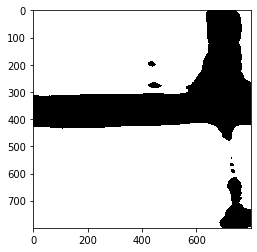

In [108]:
plt.imshow(predicted_road_map[0].cpu().data.numpy(),cmap='binary')

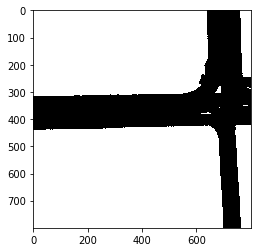

In [109]:
plt.imshow(road_image, cmap='binary')

## Extra Info

There is some extra information you can use in your model, but it is optional.

# Visualize the bounding box

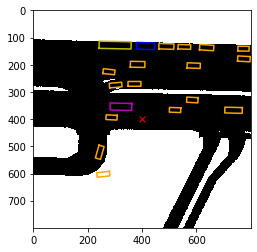

In [56]:
# The center of image is 400 * 400

fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image[0], cmap ='binary');

# The ego car position
ax.plot(400, 400, 'x', color="red")

for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])    

# Evaluation
During the whole competition, you have three submission deadlines. The dates will be announced on Piazza. You will have to fill up the template 'data_loader.py' for evaluation. (see the comment inside data_loader.py' for more information)

There will be two leaderboards for the competition:
The leaderboard for binary road map.
We will evaluate your model's performance by using the average threat score (TS) across the test set:
$$\text{TS} = \frac{\text{TP}}{\text{TP} + \text{FP} + \text{FN}}$$
The leaderboard for object detection:
We will evaluate your model's performance for object detection by using the average mean threat score at different intersection over union (IoU) thresholds.
There will be five different thresholds (0.5, 0.6, 0.7, 0.8, 0.9). For each thresholds, we will calculate the threat score. The final score will be a weighted average of all the threat scores:
$$\text{Final Score} = \sum_t \frac{1}{t} \cdot \frac{\text{TP}(t)}{\text{TP}(t) + \text{FP}(t) + \text{FN}(t)}$$
